In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [3]:
df2.iloc[:, 9:15]


,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [4]:
c=-1
P_exp=np.array(df2.iloc[:, -5:])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max, T_exp.shape, P_exp.shape

(5, 231399.5, (342,), (342, 5))

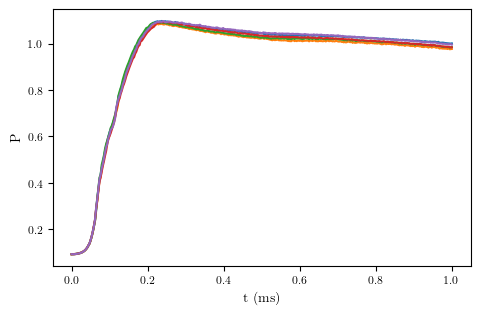

In [5]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [6]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-29 12:48:51.220701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-29 12:48:51.221036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-29 12:48:51.221375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-29 12:48:51.221653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-29 12:48:51.221939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-29 12:48:51.222264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

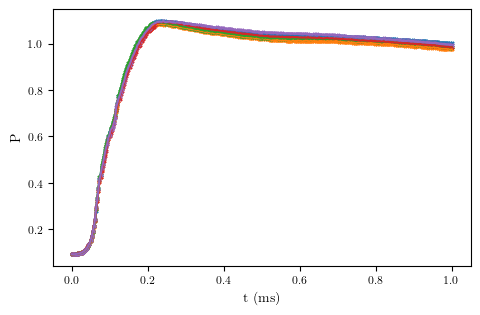

In [7]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

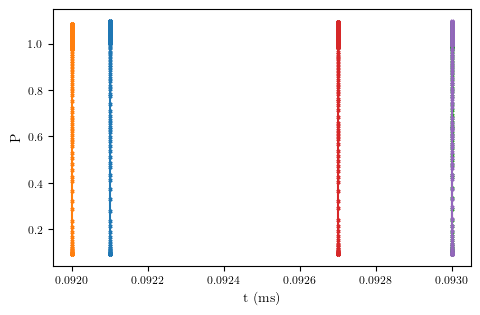

In [8]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

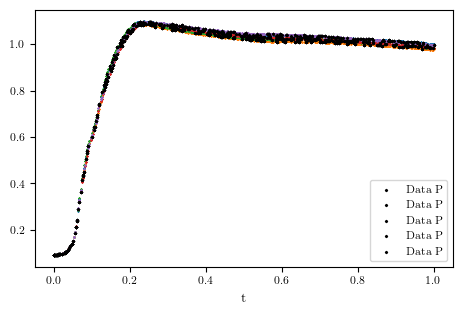

In [9]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

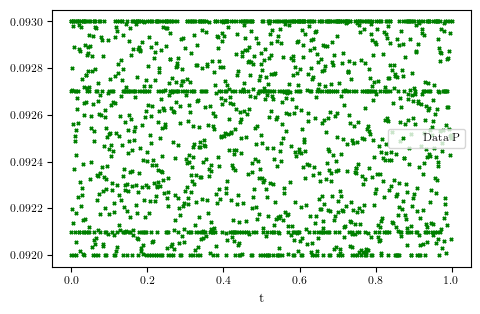

In [10]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [11]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        p=tf.exp(u)
        t=X_f[...,0:1]


        phi=net(tf.concat([p, t],1), W_phi, b_phi)


    p_t = tape1.gradient(p, X_f)[...,0:1]
    # s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p = p_t - phi*p 
    # f_s = s_t + m*p*s
    
    return f_p




#@tf.function()
@tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, lnv)




        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        # loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        # loss_fs = tf.square(lambda_r[1:2]*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)
        
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    # grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    # opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p))


layers = [2, 20, 20, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 2), (2, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [12]:
lr = 2e-3
# Nmax = 15000
# Nmax = 150000
Nmax=3*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)


In [13]:
Nmax=10**5


while n <= Nmax:
    # if n<10**5:
    loss_, loss_p, loss_fp = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # elif n< 2*10**5:
    #     loss_, loss_p, loss_fp = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    # loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        # print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 676140.375
Data loss is: 0.6761384010314941
Physicial loss of p is: 1.9916616678237915
Iteration is: 10
Total loss is: 141028.078125
Data loss is: 0.14102286100387573
Physicial loss of p is: 0.042155105620622635
Iteration is: 20
Total loss is: 67983.5078125
Data loss is: 0.06797784566879272
Physicial loss of p is: 0.1074313074350357
Iteration is: 30
Total loss is: 78092.6953125
Data loss is: 0.07808303833007812
Physicial loss of p is: 0.04581566900014877
Iteration is: 40
Total loss is: 56065.6171875
Data loss is: 0.05605509877204895
Physicial loss of p is: 0.04067414253950119
Iteration is: 50
Total loss is: 54095.26953125
Data loss is: 0.05408278852701187
Physicial loss of p is: 0.01585615798830986
Iteration is: 60
Total loss is: 53383.00390625
Data loss is: 0.05336758494377136
Physicial loss of p is: 0.01730387844145298
Iteration is: 70
Total loss is: 52527.64453125
Data loss is: 0.05250978097319603
Physicial loss of p is: 0.013747792690992355
Iteration 

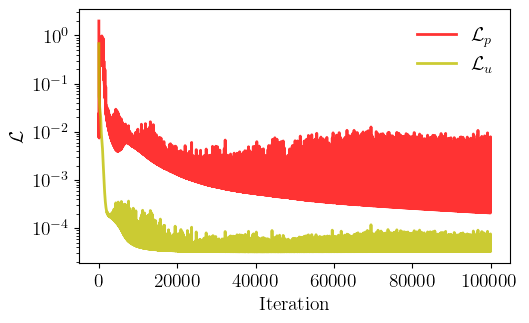

In [14]:
# Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
# loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
# plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(it, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/604/Loss_split.png')
plt.savefig('../Img/604/Loss_split.pdf')
plt.savefig('../Img/604/Loss_split.svg')
plt.show()

In [15]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
p=tf.exp(u_pred)
t=X_star_tf[...,0:1]


phi=predict(tf.concat([p, t],1), W_phi, b_phi)


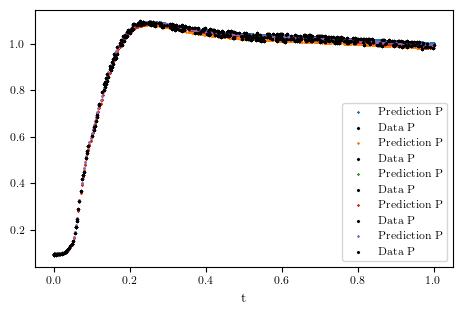

In [16]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction P')
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [17]:
# for i in range(N_exp):
#     plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction S')


# plt.legend()
# plt.xlabel('t')
# plt.yscale('log')
# # plt.xscale('log')

# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()

In [18]:
colors = plt.cm.tab10.colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


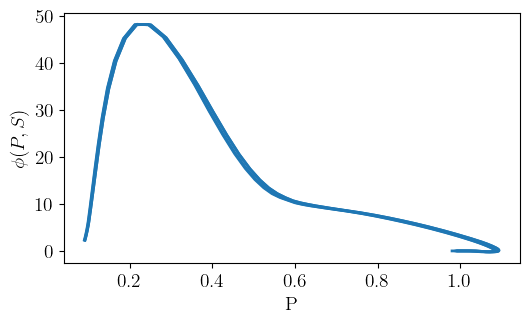

In [19]:
for i in range(1, N_exp):
    plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('P', fontsize=14)
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/604/Result_phi.png')
plt.savefig('../Img/604/Result_phi.pdf')
plt.savefig('../Img/604/Result_phi.svg')
plt.show()

In [20]:
P0, np.mean(P0)


(array([0.09210000187158585, 0.09200000017881393, 0.09300000220537186,
        0.09269999712705612, 0.09300000220537186], dtype=object),
 0.09256000071763992)

In [21]:
P0

array([0.09210000187158585, 0.09200000017881393, 0.09300000220537186,
       0.09269999712705612, 0.09300000220537186], dtype=object)

In [22]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
# S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P_int[0]=np.mean(P0) #Initial conditions
# P_int[0]=np.array(p[0]) #Initial conditions

# S_int[0]=np.array(s[0]) #Initial conditions




for i in range(1,Nt):

    PT=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI_S=tf.exp(net(PSA, W_a, b_a))
    
    PHI=net(PT, W_phi, b_phi)
    # REVISAAAAAR
    # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
    P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
    # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
    T_int[i]=T_int[i-1]+dt

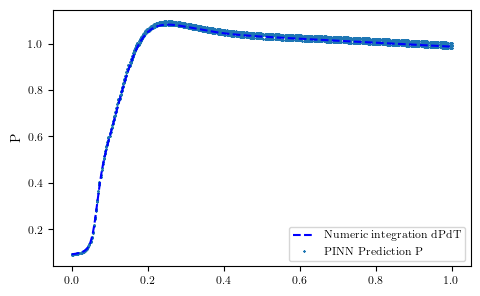

In [23]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

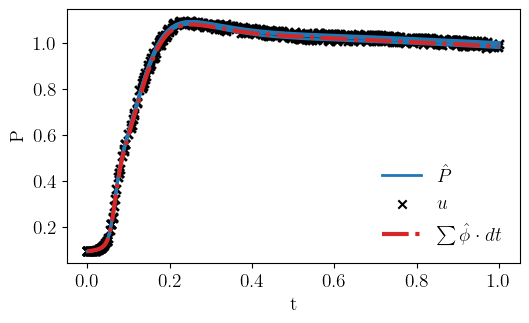

In [24]:


i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{P}$')
# plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{S}$')

plt.scatter(X_u_train[:,0], P_train, marker='x', color='black',label='$u$')
for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

plt.plot(T_int, P_int, linestyle='-.',linewidth=3, color=colors[3], label='$\sum \hat{\phi} \cdot dt$')
# plt.plot(T_int, S_int, linestyle='-.',linewidth=3, color=colors[3])
# plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.legend(fontsize=12, ncols=1, frameon=False,  bbox_to_anchor=(0.7, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/604/Result_int.png')
plt.savefig('../Img/604/Result_int.pdf')
plt.savefig('../Img/604/Result_int.svg')
plt.show()

In [25]:
fghbjknlm

NameError: name 'fghbjknlm' is not defined

# Symbolic Regresion

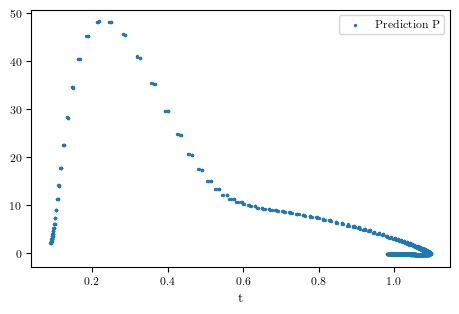

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0921], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.093    ], dtype=float32)>)

In [26]:
c=0
d=-1
plt.scatter( p[c:d],phi[c:d], s=2, label='Prediction P')
# plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

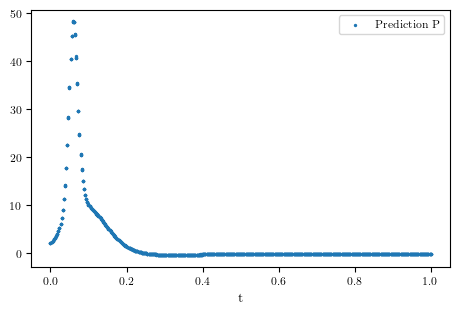

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0921], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.093    ], dtype=float32)>)

In [27]:
c=0
d=-1
plt.scatter( t,phi, s=2, label='Prediction P')
# plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

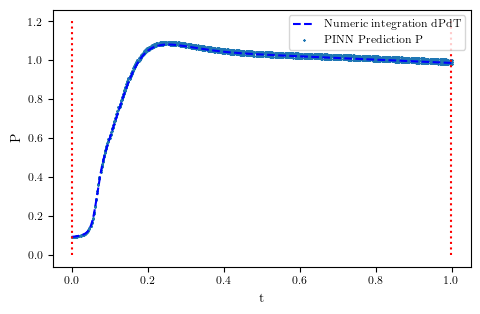

In [28]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [29]:
# Create and train the PySR model
model= PySRRegressor(
    niterations=500,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [30]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi= tf.math.reduce_min(phi[c:d], axis=0)
max_cols_phi= tf.math.reduce_max(phi[c:d], axis=0)

phi_scaled = (phi[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)
PT_tf=tf.concat([p[c:d], t[c:d]],1)

model.fit( PT_tf,phi_scaled)
print(model)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 9.520e+04
Head worker occupation: 21.5%
Progress: 212 / 7500 total iterations (2.827%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           2.380e-02  5.314e+00  y = -0.044654 * -1.2344
5           1.159e-02  3.596e-01  y = -0.42306 * (-1.0578 + x₀)
7           1.074e-02  3.826e-02  y = -0.42306 * (-1.0578 + (x₀ * x₀))
9           1.044e-02  1.403e-02  y = (-0.42306 * (-1.0578 + x₀)) * (0.88153 + x₀)
11          7.504e-03  1.652e-01  y = x₀ * (2.2935 * ((-1.0221 + x₀) * (-1.2003 + x₀)))
13          6.189e-03  9.629e-02  y = (x₀ + x₁) * (2.2935 * ((-1.0221 + x₀) * (-1.2003 + x₀)))
15          1.210e-03  8.163e-01  y = inv(inv(-0.059055, x₁) * -0.006274, x₁ + -0.059146) + -0.0...
                                  06274
17          3.161e-04  6.709e-01  y = -0.0023786 + inv((x₁ * -0.08058) * inv(-0.059041, x₁), -0....
                       

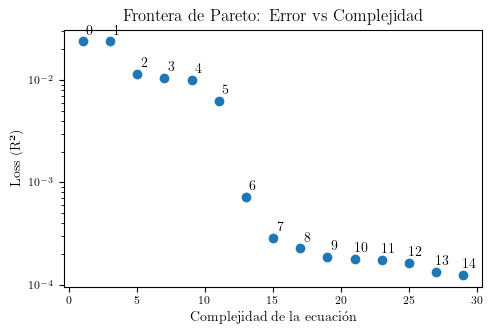

In [31]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

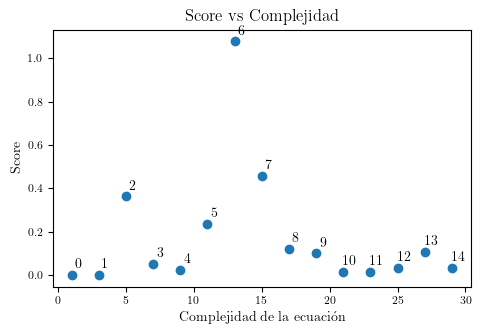

In [32]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [33]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.023796,0.000000e+00,0.05513205,0.0551320500000000,PySRFunction(X=>0.0551320500000000)
1,3,0.023796,1.050604e-07,-0.044654444 * -1.2343721,-0.044654444*(-1.2343721),PySRFunction(X=>-0.044654444*(-1.2343721))
2,5,0.011537,3.619714e-01,(-0.4468942 * x0) + 0.47449932,0.47449932 - 0.4468942*x0,PySRFunction(X=>0.47449932 - 0.4468942*x0)
3,7,0.010431,5.041505e-02,0.403976 + ((-0.37032673 * x0) * x0),-0.37032673*x0*x0 + 0.403976,PySRFunction(X=>-0.37032673*x0*x0 + 0.403976)
4,9,0.009932,2.449036e-02,(x0 * (-1.0377554 + x0)) * (-2.072965 + x0),x0*(x0 - 2.072965)*(x0 - 1.0377554),PySRFunction(X=>x0*(x0 - 2.072965)*(x0 - 1.037...
5,11,0.006228,2.333646e-01,(((x0 + -1.0311232) * (x0 + -1.0154649)) * 3.5...,(x0 - 1.0311232)*(x0 - 1.0154649)*3.55561*x0,PySRFunction(X=>(x0 - 1.0311232)*(x0 - 1.01546...
6,13,0.000722,1.077567e+00,"inv(-0.0047235154 * inv(-0.06105071, x1), x1 +...",0.000288373968865934/((x1 - 0.06105071)*(x1 - ...,PySRFunction(X=>0.000288373968865934/((x1 - 0....
7,15,0.000289,4.578438e-01,"inv(-0.004838146 * (inv(-0.059206784, x1) + -0...",-0.004838146*(-0.7462714 - 0.059206784/(x1 - 0...,PySRFunction(X=>-0.004838146*(-0.7462714 - 0.0...
8,17,0.000227,1.211020e-01,"inv(inv(-0.057457175, x1) * ((x0 + 0.13119364)...",0.000682080387257075*(x0 + 0.13119364)/((x1 - ...,PySRFunction(X=>0.000682080387257075*(x0 + 0.1...
9,19,0.000186,9.892747e-02,inv((-0.0130076585 * (0.23107255 + (x0 * x0)))...,0.000784464177822395*(x0*x0 + 0.23107255)/((x1...,PySRFunction(X=>0.000784464177822395*(x0*x0 + ...


In [34]:
for i in range(len(equations_df)):
    print(i, sympy.simplify(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 2.38219736643734
1 2.38162212691998
2 22.7394000683267 - 21.6934330991035*x0
3 19.3160105404549 - 17.9766444542462*x0**2
4 48.5426597595215*x0*(x0 - 2.072965)*(x0 - 1.0377554) - 0.294058978557587
5 172.598766467552*x0*(x0 - 1.0311232)*(x0 - 1.0154649) - 0.294058978557587
6 -0.294058978557587 - 0.0139984394541619/(-(x1 - 0.061323285)*(x1 - 0.06105071) - 0.000288373968865934)
7 48.5426597595215*(-0.0036105699888244*x1 - 7.26808277372553e-5)/((0.0562856720111756 - x1)*(x1 - 0.059206784) - 0.000286451065182464) - 0.294058978557587
8 48.5426597595215*(0.000682080387257075*x0 + 8.94846087768653e-5)/(0.000682080387257075*x0 + (x1 - 0.059257016)*(x1 - 0.057457175) + 8.94846087768653e-5) - 0.294058978557587
9 48.5426597595215*(-0.000784464177822395*x0**2 - 0.000181268137953074)/(-0.000784464177822395*x0**2 + (0.058599 - x1)*(x1 - 0.06030787) - 0.000181268137953074) - 0.294058978557587
10 0.659844403151936*(x0**2 + 0.22795054)*(0.052250568*x1 - 0.0623003720934533)/(0.013593083*(x0**2 + 0.22795

In [35]:
for i in range(len(equations_df)):
    print(i, sympy.expand(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 2.38219736643734
1 2.38162212691998
2 22.7394000683267 - 21.6934330991035*x0
3 19.3160105404549 - 17.9766444542462*x0**2
4 48.5426597595215*x0**3 - 151.002641984203*x0**2 + 104.426456184951*x0 - 0.294058978557587
5 172.598766467552*x0**3 - 353.238581527171*x0**2 + 180.722889810421*x0 - 0.294058978557587
6 -0.294058978557587 + 0.0139984394541619/(x1**2 - 0.122373995*x1 + 0.000288373968865934*x1/(x1 - 0.06105071) + 0.00374383008878235 - 1.76054355447832e-5/(x1 - 0.06105071))
7 -0.294058978557587 + 0.0139050965949049/(x1**2 - 0.115492456011176*x1 + 0.000286451065182464*x1/(x1 - 0.059206784) + 0.00333249362506052 - 1.69598463428281e-5/(x1 - 0.059206784)) + 0.175266670505442/(x1 - 0.0562856720111756 + 0.000286451065182464/(x1 - 0.059206784))
8 0.0331099961672628*x0/(0.000682080387257075*x0*x1/(x1 - 0.057457175) - 3.91904121746975e-5*x0/(x1 - 0.057457175) + x1**2 - 0.116714191*x1 + 8.94846087768653e-5*x1/(x1 - 0.057457175) + 0.0034047407382898 - 5.14153282629888e-6/(x1 - 0.057457175)) - 0.

In [36]:
for i in range(len(equations_df)):
    print(i, sympy.factor(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 2.38219736643734
1 2.38162212691998
2 22.7394000683267 - 21.6934330991035*x0
3 19.3160105404549 - 17.9766444542462*x0**2
4 104.426456184951*x0*(0.482400812362968*x0 - 1.0)*(0.963618209069305*x0 - 1.0) - 0.294058978557587
5 180.722889810421*x0*(0.969816215947813*x0 - 1.0)*(0.984770620825988*x0 - 1.0) - 0.294058978557587
6 -0.294058978557587 + 0.0139984394541619/(1.0*x1**2 - 0.122373995*x1 + 0.00403220405764828)
7 0.175266670505442*(1.0*x1 + 0.0201300149179272)/(1.0*x1**2 - 0.115492456011176*x1 + 0.00361894469024298) - 0.294058978557587
8 0.0331099961672628*(1.0*x0 + 0.13119364)/(0.000682080387257075*x0 + 1.0*x1**2 - 0.116714191*x1 + 0.00349422534706667) - 0.294058978557587
9 0.0380799776775653*(1.0*x0**2 + 0.23107255)/(0.000784464177822395*x0**2 + 1.0*x1**2 - 0.11890687*x1 + 0.00371524901208307) - 0.294058978557587
10 0.0411085518401482*(1.0*x0**2 + 0.22795054)*(0.83868789614325*x1 - 1.0)/(0.000710246307621144*x0**2*x1 - 0.000846854128797195*x0**2 - 1.0*x1**2 + 0.118924398029355*x1 - 

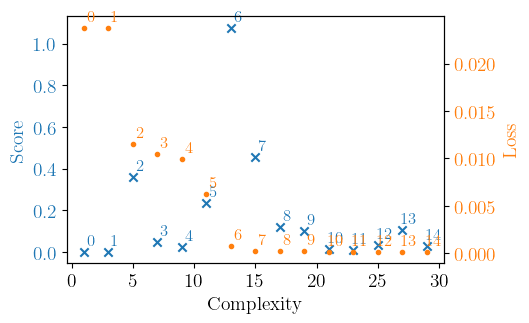

In [37]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Img/604/Score_Loss_Complexity.png')
plt.savefig('../Img/604/Score_Loss_Complexity.pdf')
plt.savefig('../Img/604/Score_Loss_Complexity.svg')
plt.show()


In [70]:
choose=2
choose_2=3
choose_3=6

exp=model.sympy(choose)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_2=model.sympy(choose_2)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_3=model.sympy(choose_3)*(max_cols_phi-min_cols_phi)+min_cols_phi

In [71]:
sympy.factor(exp)

-22.7394000683267*(0.954001998026321*x0 - 1.0)

In [72]:
sympy.factor(exp_2)

-19.3160105404549*(0.930660315006375*x0**2 - 1.0)

In [73]:
sympy.factor(exp_3)

-0.294058978557587*(1.0*x1**2 - 0.122373995*x1 - 0.0435719858325118)/(1.0*x1**2 - 0.122373995*x1 + 0.00403220405764828)

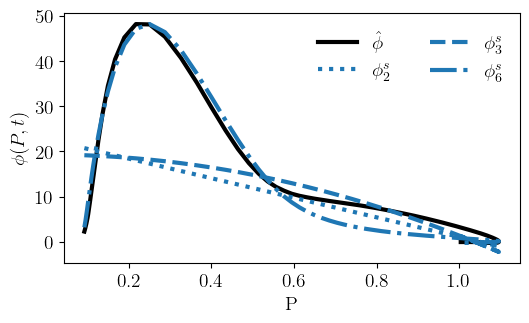

In [105]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='black', label='$\hat{\phi}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_2$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_{3}$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_{6}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('P', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/604/Result_phi_s.png')
plt.savefig('../Img/604/Result_phi_s.pdf')
plt.savefig('../Img/604/Result_phi_s.svg')
plt.show()


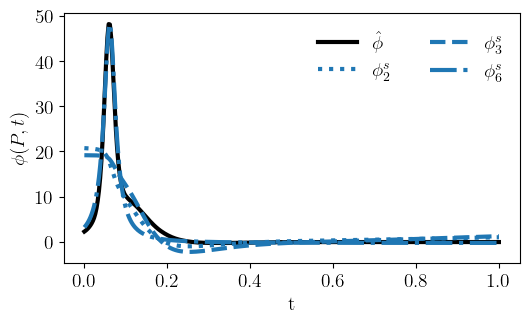

In [104]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='black', label='$\hat{\phi}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_2$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_{3}$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_{6}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('t', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/604/Result_phi_t.png')
plt.savefig('../Img/604/Result_phi_t.pdf')
plt.savefig('../Img/604/Result_phi_t.svg')
plt.show()


In [76]:
Nt=10000
P_symb_1=np.zeros(Nt)
P_symb_2=np.zeros(Nt)
P_symb_3=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_1[0]=P_symb_2[0]=P_symb_3[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_1[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_1[i]=P_symb_1[i-1]+(PHI_S*P_symb_1[i-1])*dt
    # S_symb_1[i]=S_symb_1[i-1]-P_symb_3[i-1]*S_symb_1[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_2[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_2[i]=P_symb_2[i-1]+(PHI_S*P_symb_2[i-1])*dt
    # S_symb_2[i]=S_symb_2[i-1]-P_symb_2[i-1]*S_symb_2[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_3[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_3[i]=P_symb_3[i-1]+(PHI_S*P_symb_3[i-1])*dt
    # S_symb_3[i]=S_symb_3[i-1]-P_symb_3[i-1]*S_symb_3[i-1]*np.array(m)*dt

    T_symb[i]=T_symb[i-1]+dt

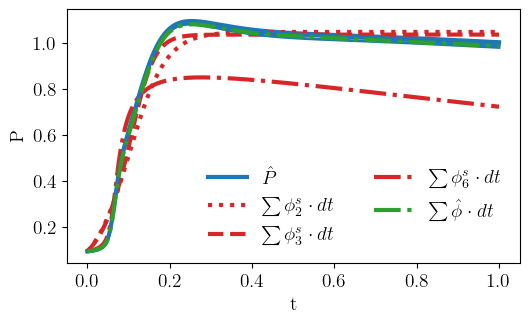

In [80]:
i=0

plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_{2} \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{3} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{6} \cdot dt$')

for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')


plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/604/Result_int_s_p.png')
plt.savefig('../Img/604/Result_int_s_p.pdf')
plt.savefig('../Img/604/Result_int_s_p.svg')
plt.show()

In [188]:
sdfghjkl

NameError: name 'sdfghjkl' is not defined

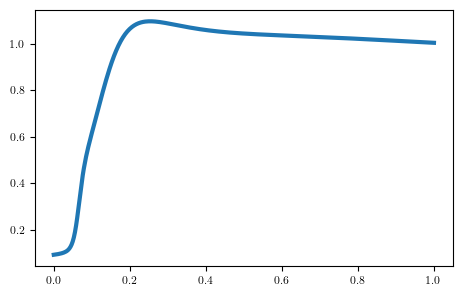

In [56]:
plt.plot(t[:L_exp], p[:L_exp], linewidth=3, label='$\hat{P}$')

In [57]:
# T_symb=np.linspace(0,1,1000)
# P0=np.repeat(np.mean(P_exp[::L_exp]), len(T_symb))
# X_star_symb=np.vstack((T_symb,P0)).T
# X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
# u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
# p_symb=p[:L_exp]
# t_symb=t[:L_exp]
p_symb=tf.convert_to_tensor(P_int.reshape([-1,1]), dtype=tf.float32)
t_symb=tf.convert_to_tensor(T_int.reshape([-1,1]), dtype=tf.float32)

# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi_symb=net(tf.concat([p_symb, t_symb],1), W_phi, b_phi)

In [58]:
import numpy as np
import pysindy as ps

# Supongamos que PT_tf tiene las columnas [P, T] y phi_scaled es un array
P = p_symb  # Primera columna (P)
T = t_symb  # Segunda columna (T)
min_cols_phi_p= tf.math.reduce_min(phi_symb, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi_symb, axis=0)

phi_scaled = (phi_symb-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

phi_scaled = np.array(phi_scaled)[:,0] # Datos de phi_scaled

# Combinar P y T en una matriz de entrada
X = np.column_stack([P, T])

In [78]:
# Configurar la librería de funciones
library = ps.PolynomialLibrary(degree=1)  # Hasta tercer grado polinomial


# Crear el modelo SINDy con optimizador
model_s = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.001))
# Ajustar el modelo a los datos
model_s.fit(X, x_dot=phi_scaled)  # Aquí phi_scaled se interpreta como "derivadas" del sistema

# Imprimir la ecuación aprendida
model_s.print()

(x0)' = 0.473 1 + -0.407 x0 + -0.079 x1


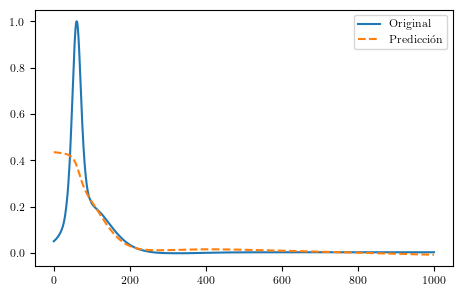

In [79]:
predicted_phi = model_s.predict(X)

# Comparar predicción con phi_scaled original
import matplotlib.pyplot as plt
plt.plot(phi_scaled, label="Original")
plt.plot(predicted_phi, label="Predicción", linestyle="dashed")
plt.legend()
plt.show()

In [83]:
Nt=10000
P_symb_s=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_s[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_s[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model_s.predict(PT).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_s[i]=P_symb_s[i-1]+(PHI_S*P_symb_s[i-1])*dt
    T_symb[i]=T_symb[i-1]+dt

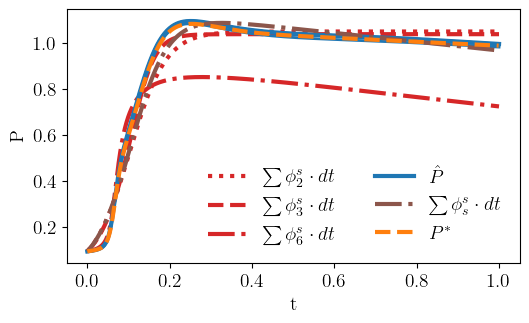

In [109]:
i=0

plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_2 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{3} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{6} \cdot dt$')

for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
plt.plot(T_symb, P_symb_s, color=colors[5],linestyle='-.',linewidth=3, label='$\sum \phi^s_{s} \cdot dt$')

# plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')

plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/604/Result_int_sindy.png')
plt.savefig('../Img/604/Result_int_sindy.pdf')
plt.savefig('../Img/604/Result_int_sindy.svg')
plt.show()

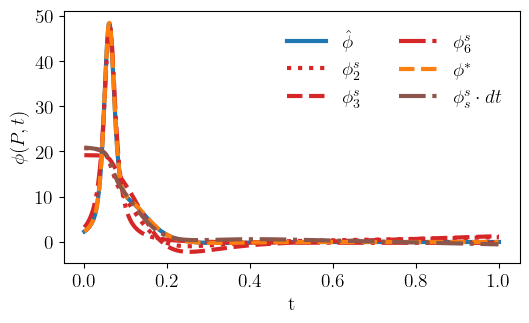

In [107]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color=colors[0], label='$\hat{\phi}$')
for i in range(1, N_exp):
    plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[3], linestyle=':', label='$\phi^s_2$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[3], linestyle='--', label='$\phi^s_{3}$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[3],linestyle='-.', label='$\phi^s_{6}$')
plt.plot(T, phi_symb, linestyle='--',linewidth=3, color=colors[1], label='$\phi^*$')
plt.plot(T, predicted_phi*(max_cols_phi-min_cols_phi)+min_cols_phi, color=colors[5],linestyle='-.',linewidth=3, label='$\phi^s_{s} \cdot dt$')

# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('t', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()
plt.savefig('../Img/604/Result_phi_sindy_t.png')
plt.savefig('../Img/604/Result_phi_sindy_t.pdf')
plt.savefig('../Img/604/Result_phi_sindy_t.svg')
plt.show()

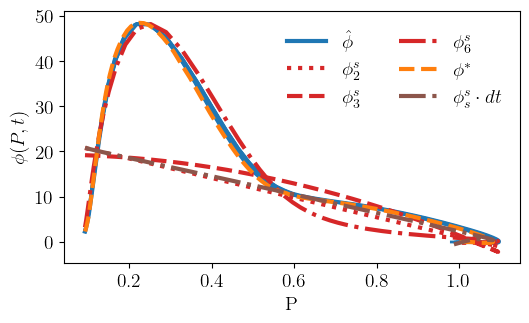

In [106]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color=colors[0], label='$\hat{\phi}$')
for i in range(1, N_exp):
    plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[3], linestyle=':', label='$\phi^s_2$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[3], linestyle='--', label='$\phi^s_{3}$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[3],linestyle='-.', label='$\phi^s_{6}$')
plt.plot(P, phi_symb, linestyle='--',linewidth=3, color=colors[1], label='$\phi^*$')
plt.plot(P, predicted_phi*(max_cols_phi-min_cols_phi)+min_cols_phi, color=colors[5],linestyle='-.',linewidth=3, label='$\phi^s_{s} \cdot dt$')

# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


# plt.xlabel('t', fontsize=14, color='black')

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()
plt.savefig('../Img/604/Result_phi_sindy_p.png')
plt.savefig('../Img/604/Result_phi_sindy_p.pdf')
plt.savefig('../Img/604/Result_phi_sindy_p.svg')
plt.show()